<a href="https://colab.research.google.com/github/Fredooooooo/JSC270_Assg4/blob/main/JSC270_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
api_key = 'RnHS3Y3lkrv9pzkHVFcVYVArH'
api_secret_key = 'xLMxTxhEHluPlcsPgb2rur07hBR4qSuzGdIVhJg0hpEiR1nTBm'
access_key = '1376070608950267904-AlJkcNLLxsAByp9NmFU854synmuzq5'
access_secret = 'dtH18I0v8Ob44BAUXhrJB9TNvnFfQykBafXY4fl4JtdJB'

In [3]:
import re
import numpy as np
import pandas as pd 
import io
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_curve
import matplotlib.pyplot as plt

In [25]:
import tweepy as tw
# Use credentials to authorize access
auth = tw.OAuthHandler(api_key, api_secret_key)
auth.set_access_token(access_key, access_secret)
api = tw.API(auth, wait_on_rate_limit=True)
search_words = ' -filter:retweets'
date_since = "2021-03-09"

#Collect tweets (here, I get only 20)
tweets = tw.Cursor(api.search,
              q=search_words,
              lang="en",
              since=date_since).items(2000)

# The result is an iterable
a = []
b = []
for tweet in tweets:
  a.append(tweet.text)
  b.append(tweet.user.followers_count)

In [26]:
import pandas as pd
import re

# tweet_list = [tweet.text for tweet in tweets]
df = pd.DataFrame(a, columns = ['tweet'])
df['followers'] = b
print(df.count())

tweet        2000
followers    2000
dtype: int64


In [27]:
handle_regex = '@[A-Za-z|0-9|_]+'

d = []
for row in df['tweet']:
  d.append(re.sub(handle_regex,'', row))

df['tweet'] = d
df.head()

tweet  followers
0    No. Activate chief. It‚Äôs obvious that he sai...         16
1   Woah lol we suppose to be on the same team ch...       1683
2  i know donghan wears contacts sometimes but li...       1980
3   I hear you adopted that kitty. So I‚Äôll give i...         81
4                  The X-men analyzer has logged on.         93

In [28]:
c = []
for x in df['followers']:
  if 0 <= x <= 100:
    c.append(0)
  elif 100 < x <= 10000:
    c.append(1)
  else:
    c.append(2)
df['labels'] = c
df.head()

tweet  followers  labels
0    No. Activate chief. It‚Äôs obvious that he sai...         16       0
1   Woah lol we suppose to be on the same team ch...       1683       1
2  i know donghan wears contacts sometimes but li...       1980       1
3   I hear you adopted that kitty. So I‚Äôll give i...         81       0
4                  The X-men analyzer has logged on.         93       0

In [29]:
low_proportion = df['labels'].tolist().count(0)
medium_proportion = df['labels'].tolist().count(1)
high_proportion = df['labels'].tolist().count(2)
print(low_proportion, medium_proportion, high_proportion)
print(df.followers.mean)

482 1455 63
<bound method Series.mean of 0         16
1       1683
2       1980
3         81
4         93
        ... 
1995     276
1996      18
1997     448
1998       4
1999      41
Name: followers, Length: 2000, dtype: int64>


In [30]:
import nltk
# Download the tokenizer
nltk.download('punkt')

# Create a new column in our DF that contains token lists instead of raw text
df['tokens'] = df['tweet'].apply(nltk.word_tokenize)

print(df['tokens'].head(5))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
0    [No, ., Activate, chief, ., It, ‚Äô, s, obvious,...
1    [Woah, lol, we, suppose, to, be, on, the, same...
2    [i, know, donghan, wears, contacts, sometimes,...
3    [I, hear, you, adopted, that, kitty, ., So, I,...
4           [The, X-men, analyzer, has, logged, on, .]
Name: tokens, dtype: object


In [31]:
##### Convert tokens into lowercase ####
lowercase_tokens = []
# Create a list of lists with what we want
for row in df['tokens']:
  lowercase_tokens.append([t.lower() for t in row])
# add the new info to our df
df['lowercase_tokens'] = lowercase_tokens

print(df['lowercase_tokens'].head(5))

0    [no, ., activate, chief, ., it, ‚Äô, s, obvious,...
1    [woah, lol, we, suppose, to, be, on, the, same...
2    [i, know, donghan, wears, contacts, sometimes,...
3    [i, hear, you, adopted, that, kitty, ., so, i,...
4           [the, x-men, analyzer, has, logged, on, .]
Name: lowercase_tokens, dtype: object


In [32]:
##### Let's remove punctuation #####

# Note we've been keeping different columns for different steps (not necessary)
list(df)

# Same process as before
tokens_no_punct = []
# Create a list of lists with what we want
for row in df['lowercase_tokens']:
  tokens_no_punct.append([re.sub('[^\w\s]','', t) for t in row])
# add the new info to our df
df['tokens_no_punct'] = tokens_no_punct

print(df['tokens_no_punct'].head(5))

0    [no, , activate, chief, , it, , s, obvious, th...
1    [woah, lol, we, suppose, to, be, on, the, same...
2    [i, know, donghan, wears, contacts, sometimes,...
3    [i, hear, you, adopted, that, kitty, , so, i, ...
4             [the, xmen, analyzer, has, logged, on, ]
Name: tokens_no_punct, dtype: object


In [33]:
##### Time to remove Stopwords #####
import numpy as np
from nltk.corpus import stopwords
nltk.download('stopwords')
sw = stopwords.words('english')[:75]
tokens_no_sw = []
for row in df['tokens_no_punct']:
  tokens_no_sw.append([w for w in row if w not in sw])
# Add column to df
df['tokens_no_sw'] = tokens_no_sw

# Print some examples
print(df['tokens_no_sw'].head(5))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
0    [no, , activate, chief, , , s, obvious, said, ...
1    [woah, lol, suppose, to, on, same, team, chill...
2    [know, donghan, wears, contacts, sometimes, li...
3    [hear, adopted, kitty, , so, , ll, give, to, y...
4                       [xmen, analyzer, logged, on, ]
Name: tokens_no_sw, dtype: object


In [34]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
stemmed_tokens = []
for row in df['tokens_no_sw']:
  stemmed_tokens.append([stemmer.stem(t) for t in row])

df['stemmed_tokens'] = stemmed_tokens
print('Before stemming:\n', df['tokens_no_sw'].head(3))
print('After stemming:\n', df['stemmed_tokens'].head(3))

Before stemming:
 0    [no, , activate, chief, , , s, obvious, said, ...
1    [woah, lol, suppose, to, on, same, team, chill...
2    [know, donghan, wears, contacts, sometimes, li...
Name: tokens_no_sw, dtype: object
After stemming:
 0    [no, , activ, chief, , , s, obviou, said, , , ...
1    [woah, lol, suppos, to, on, same, team, chill,...
2    [know, donghan, wear, contact, sometim, like, ...
Name: stemmed_tokens, dtype: object


In [35]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
lem_tokens = []
for row in df['tokens_no_sw']:
  lem_tokens.append([lemmatizer.lemmatize(t) for t in row])

df['lem_tokens'] = lem_tokens

# Print results
print(df['lem_tokens'].head(5))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
0    [no, , activate, chief, , , s, obvious, said, ...
1    [woah, lol, suppose, to, on, same, team, chill...
2    [know, donghan, wear, contact, sometimes, like...
3    [hear, adopted, kitty, , so, , ll, give, to, y...
4                       [xmen, analyzer, logged, on, ]
Name: lem_tokens, dtype: object


In [36]:
# Drop some intermediate columns
list(df)
df = df.drop(['tokens','lowercase_tokens', 'tokens_no_punct','tokens_no_sw','stemmed_tokens'], axis = 1)

print('After removal:\n', list(df))

# Remove blank tokens
no_blanks = []
for row in df['lem_tokens']:
  no_blanks.append([t for t in row if t != ''])
df['tokens'] = no_blanks

print(df['tokens'].head(5))

# drop the last intermediate column
df = df.drop(['lem_tokens'], axis = 1)

# Now we should have only the label, original text, and cleaned token lists
print('Current Columns:\n',list(df))

After removal:
 ['tweet', 'followers', 'labels', 'lem_tokens']
0    [no, activate, chief, s, obvious, said, s, hater]
1    [woah, lol, suppose, to, on, same, team, chill...
2    [know, donghan, wear, contact, sometimes, like...
3    [hear, adopted, kitty, so, ll, give, to, ya, f...
4                         [xmen, analyzer, logged, on]
Name: tokens, dtype: object
Current Columns:
 ['tweet', 'followers', 'labels', 'tokens']


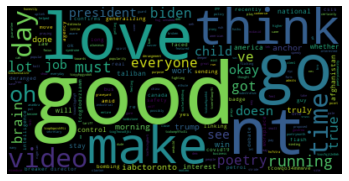

In [43]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
popular = df['labels'] > 1
df_pop = df[popular]
text = []
for lst in df_pop['tokens']:
  text.extend(lst)
text = ' '.join(text)
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

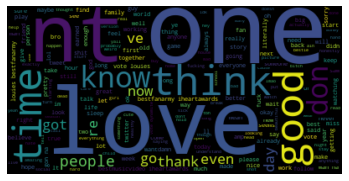

In [45]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
popular = df['labels'] == 1
df_less_pop = df[popular]
text = []
for lst in df_less_pop['tokens']:
  text.extend(lst)
text = ' '.join(text)
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

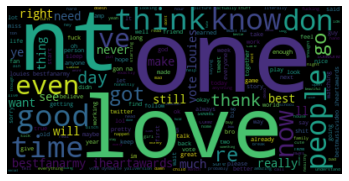

In [46]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
popular = df['labels'] == 1
df_lst_pop = df[popular]
text = []
for lst in df_lst_pop['tokens']:
  text.extend(lst)
text = ' '.join(text)
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [38]:
df_pop.head()

tweet  ...                                             tokens
35                                       love u more ü§ç  ...                                    [love, u, more]
44   Whether America Stays or Goes, the Taliban Wil...  ...  [whether, america, stay, go, taliban, will, co...
109    Yes me too, not generalizing, it's just the ...  ...  [yes, too, not, generalizing, s, just, derange...
165   As long as they don't flash more than their  ...  ...  [long, nt, flash, more, than, badge, before, m...
219  Do you not think the guys petrol bombing a bus...  ...  [not, think, guy, petrol, bombing, bus, in, vi...

[5 rows x 4 columns]

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

# Separate labels from features, converting to numpy arrays
X, y = df['tokens'].to_numpy(), df['labels'].to_numpy()


def override_fcn(doc):
  # We expect a list of tokens as input
  return doc

# Count Vectorizer
count_vec = CountVectorizer(
    analyzer='word',
    tokenizer= override_fcn,
    preprocessor= override_fcn,
    token_pattern= None)

# Remember this output is a Scipy Sparse Array
counts = count_vec.fit_transform(X)
print(counts.toarray())

# Print the names of each of the features (1000 total))
print(count_vec.get_feature_names())
# Print this mapping as dictionary
print(count_vec.vocabulary_)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['0', '02', '03', '07', '0x3bc690c604d170bb53c155cb66074b4de1172c36', '1', '10', '100', '1000', '10000', '1015', '105', '108', '10k', '10pm', '11', '1151', '115k', '11th', '12', '1200', '12pm', '13', '13m', '14', '15', '150', '16', '1617831705626', '17', '18', '182713', '1918', '1939', '1st', '2', '20', '2000', '20000', '2008', '2010', '2012', '2019', '2020', '2021', '21', '214148', '21p', '22', '234802650', '234whatsapp', '23april2017', '24', '24h', '2500', '25k', '25m', '27', '28', '29', '2d', '2hrs', '2k', '2nd', '3', '30', '3000', '30mg', '31120', '321321312', '324', '33505', '35', '3590', '39', '3am', '3eyal', '3rd', '4', '40', '400', '42', '425', '428', '437', '47', '47260', '4day', '5', '50', '504', '50k', '52', '5am', '5th', '6', '600', '68', '696c8432', '6am', '7', '70', '70k', '75hard', '7th', '8', '80', '800', '8th', '9', '92', '930', '95', '99', '_', 'a3',

In [40]:
#### TF-IDF Vectorize ####

# Note that smoothing is done by default
tfidf = TfidfTransformer()

tfs = tfidf.fit_transform(counts)

# Let's use the TFIDF counts for modelling
X = tfs.toarray()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# First three rows of training features and labels

Test accuracy with simple Naive Bayes: 0.7275
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.73      1.00      0.84       291
           2       0.00      0.00      0.00         9

    accuracy                           0.73       400
   macro avg       0.24      0.33      0.28       400
weighted avg       0.53      0.73      0.61       400



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


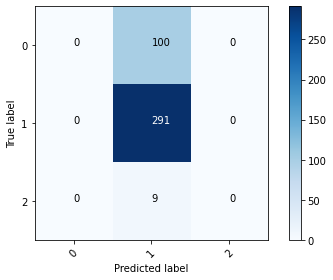

In [41]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

# Let's fit the Naive Bayes model to our training data
nb = MultinomialNB()
# Fit model to training data
nb.fit(X_train, y_train)
# Predict on test data
y_preds = nb.predict(X_test)

print('Test accuracy with simple Naive Bayes:',accuracy_score(y_test,y_preds))

# fpr, tpr, thresholds = roc_curve(y_test, y_preds, pos_label = 1)

# plt.plot(fpr,tpr)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operator Characteristic (ROC) Curve for RF')
# plt.show()

labels = [0,1,2]
print(classification_report(y_test, y_preds, labels)) #classification report from sklearn
cnf_matrix = confusion_matrix(y_test, y_preds, labels=labels)
plt.imshow(cnf_matrix, cmap=plt.cm.Blues) #plot confusion matrix grid
threshold = cnf_matrix.max() / 2 #threshold to define text color
for i in range(cnf_matrix.shape[0]): #print text in grid
    for j in range(cnf_matrix.shape[1]): 
        plt.text(j, i, cnf_matrix[i,j], color="w" if cnf_matrix[i,j] > threshold else 'black')
tick_marks = np.arange(len(labels)) #define labeling spacing based on number of classes
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.tight_layout()